In [1]:
import re
import numpy as np
import pandas as pd
import calendar
from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.cm as cmlib
import matplotlib.ticker as plticker
import datetime as dt2
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.weightstats as smS

WMN = 'WMN'
WSL = 'WSL'
UNKNOWN = 'UNK'
OTHER = 'Other'

AC, FB ='AC','FB'
PE, ALK = 'PE','ALK'
PVC = 'PVC'
CI, CLCI, DI, ELCI, CLDI, GI = 'CI','CLCI', 'DI', 'ELCI', 'CLDI','GI'
IRON='Iron'

MAX_PERCEN_TOSHOW = 2

MAX_PRERanges='PreMax_Range'
LBL_MAX_PRE = 'Max pressure (m)'
LBL_PRE_FLU = 'Pressure fluctuation (m)'

INSERV_PROCESS = 'In Service'
MATERIALS_PREDOMI = [AC,PVC,IRON,PE]

Age_Range = np.arange(0, 115, 5).tolist()
AgeR_labels = [str(i) for i in np.arange(0, 110, 5).tolist()]

Diam_bins = [25 ,75, 115, 135, 165, 190, 225,275,800]
DRange_labels = ['50', '100', '125','150','175','200','250','>300']

PressMax_bins = [20,50,60,70,80,90,110]
PMaxRange_labels = ['(20,50]','(50,60]','(60,70]','(70,80]','(80,90]','(90,110]']

PressFluc_bins = [0,3,6,9,12,15,20,35]
PFlucRange_labels = ['(0,3]','(3,6]','(6,9]','(9,12]','(12,15]','(15,20]','(20,35]']

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
plt.rc('font', size=14)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.rc('axes', labelsize=14)
plt.rcParams['legend.facecolor'] = 'white'

In [2]:
def getFailureCosts(numFailureRecordsOri,fname):
    
    #Reads the cvs file result from the query to the Watercare DB and store it in a dataframe
    failureCost = pd.read_csv(fname, delimiter = ',', 
                                 usecols=[7,2],
                                 dtype = {SERVNO:'str','WoCost':'float64'},
                                )[[SERVNO,'WoCost']]
      
    failRecCosts=failureCost.groupby([SERVNO]).agg({'WoCost': sum})

    return failRecCosts

In [3]:
def getAssetsSERVRecords():

    fname = 'Data/Assets/001-All-Assets_1.csv'
    fname2 = 'Data/Assets/001-All-Assets_2.csv'
    fname3 = 'Data/Assets/001-All-Assets_3.csv'

    AllAssets = pd.read_csv(fname, delimiter = ',', index_col=['Asset Compkey'],
                        dtype = {'Asset Type Code':'str','Asset Service Status':'str','Asset Status':'str','Asset Compkey':'int64','Water Service Line Pipe Type':'str' },     
                        usecols=[1,2,3,7,23,24])
    AllAssets2 = pd.read_csv(fname2, delimiter = ',', index_col=['Asset Compkey'],
                        dtype = {'Asset Type Code':'str','Asset Service Status':'str','Asset Status':'str','Asset Compkey':'int64','Water Service Line Pipe Type':'str' },     
                        usecols=[1,2,3,7,23,24])
    AllAssets3 = pd.read_csv(fname3, delimiter = ',', index_col=['Asset Compkey'],
                        dtype = {'Asset Type Code':'str','Asset Service Status':'str','Asset Status':'str','Asset Compkey':'int64','Water Service Line Pipe Type':'str' },     
                        usecols=[1,2,3,7,23,24])

    AllAssetsCom = AllAssets.append(AllAssets2).append(AllAssets3).copy()

    waterSL= AllAssetsCom[AllAssetsCom['Asset Type Code'] == WSL].copy()

    print("There are ", waterSL.shape[0], " water mains in the database (NOT GIS)")

    waterSL = waterSL[~waterSL.index.duplicated(keep='first')]

    print("There are ", waterSL.shape[0], " water mains not duplicated in the database (NOT GIS)")
    
    #rename the index
    waterSL.index.names = [COMPKEY]

    return waterSL


def getAssetsRecords():

    fname = 'Data/Assets/001-All-Assets_1.csv'
    fname2 = 'Data/Assets/001-All-Assets_2.csv'
    fname3 = 'Data/Assets/001-All-Assets_3.csv'

    AllAssets = pd.read_csv(fname, delimiter = ',', index_col=['Asset Compkey'],
                        dtype = {'Asset Type Code':'str','Asset Service Status':'str','Asset Status':'str','Asset Compkey':'int64' },     
                        usecols=[1,2,3,4,5,6,7])
    AllAssets2 = pd.read_csv(fname2, delimiter = ',', index_col=['Asset Compkey'],
                        dtype = {'Asset Type Code':'str','Asset Service Status':'str','Asset Status':'str','Asset Compkey':'int64' },     
                        usecols=[1,2,3,4,5,6,7])
    AllAssets3 = pd.read_csv(fname3, delimiter = ',', index_col=['Asset Compkey'],
                        dtype = {'Asset Type Code':'str','Asset Service Status':'str','Asset Status':'str','Asset Compkey':'int64' },     
                        usecols=[1,2,3,4,5,6,7])

    AllAssetsCom = AllAssets.append(AllAssets2).append(AllAssets3).copy()

    WaterMain = AllAssetsCom[AllAssetsCom['Asset Type Code'] == WMN].copy()
    
    #waterSL= AllAssetsCom[AllAssetsCom['Asset Type Code'] == WSL].copy()

    print("There are ", WaterMain.shape[0], " water mains in the database (NOT GIS)")

    waterMains = WaterMain[~WaterMain.index.duplicated(keep='first')]

    print("There are ", WaterMain.shape[0], " water mains not duplicated in the database (NOT GIS)")
    
    #rename the index
    waterMains.index.names = [COMPKEY]

    return waterMains


def getFailureRecords(numFailureRecordsOri):
    #Reads the cvs file result from the query to the Watercare DB and store it in a dataframe
    failureRecords = pd.read_csv(fname, delimiter = ',', 
                                 usecols=[0,1,7,9,8,5],
                                 dtype = {WONO:'str', ACTCODE:'str',SERVNO:'str',WC.SR_PROB:'str',
                                          ADDDTTM:'str', COMPKEY:'int64'},
                                 index_col=0,
                                 parse_dates=[ADDDTTM],
                                )[[SERVNO,ACTCODE,WC.SR_PROB,ADDDTTM,COMPKEY]]
    numFailureRecordsOri= failureRecords.shape[0]
    print('Number of records from the DB query:' , numFailureRecordsOri)

    failureRecords= failureRecords[~failureRecords.index.duplicated()].copy()

    print('Number of failure records:', failureRecords.shape[0], ' Deleted records duplicated WONO: ', numFailureRecordsOri - failureRecords.shape[0])
    numFailureRecordsOri = failureRecords.shape[0]

    #For this study if it is the same type of Repair activity on the same asset associated 
    #to the same service number and in the same date 
    #The duplicated values are due diferencees in the contractor reference numbers used to add parts of the costs.
    #therefore the duplicates are not necesary unless the cost is needed
    failureRecords.drop_duplicates(inplace=True)

    #check for duplicates using only the date (not datetime) in the extraMethods.py file!!

    print('Number of failure records:', failureRecords.shape[0], ' Deleted records: ', numFailureRecordsOri - failureRecords.shape[0])
    numFailureRecordsOri = failureRecords.shape[0]
    return failureRecords, numFailureRecordsOri

def getFilterCodesAndSR() :

	fileACTCODE = 'Data/01-ACTCODERepair.csv'
	fileSR_Prob = 'Data/02-SR_PROB_TO_FILTER.csv'

	#read the filter files
	ACTCODERepair = pd.read_csv(fileACTCODE)
	SR_ToFilter = pd.read_csv(fileSR_Prob)

	return ACTCODERepair, SR_ToFilter

def filters3PandNotRepairs(failureRecords, SR_ToFilter, ACTCODERepair, numFailureRecordsOri):
	#filters the service codes related to third parties---------------------------------------------------------------
    failureRecords= failureRecords[~failureRecords[WC.SR_PROB].isin(SR_ToFilter['SR_PROB_TO_FILTER'])].copy()
    
    print('Number of failure records:', failureRecords.shape[0], ' 3P Deleted records: ', numFailureRecordsOri - failureRecords.shape[0])
    numFailureRecordsOri = failureRecords.shape[0]


	#filters the activities with actcodes not related to repairs------------------------------------------------------
    failureRecords= failureRecords[failureRecords[ACTCODE].isin(ACTCODERepair[ACTCODE])].copy()
    
    print('Number of failure records:', failureRecords.shape[0], ' Not repair Deleted records: ', numFailureRecordsOri - failureRecords.shape[0])
    numFailureRecordsOri = failureRecords.shape[0]
    
    return failureRecords, numFailureRecordsOri

def getAddressFromFailureRecords():

	addressRecords = pd.read_csv(fname, delimiter = ',', 
								usecols=[0,12,13,14,15,16,17],
								dtype = {WONO:'str', 'Street_Type':'str','Street_Name':'str',SUBURB:'str',
								'FLAT':'str','HOUSENO':'str','POSTCODE':'str'})

	addressRecords.drop_duplicates(inplace=True)
	addressRecords.set_index(WONO, inplace=True, drop=True)

	return addressRecords

def filterFailuresbyInconsistentAddress(failures, addressRecords, assetAddresses):

	#adds the compkeys to the addressess of the failure table 
    failAddr= failures.join(addressRecords)[[COMPKEY,'Street_Type','Street_Name',SUBURB]]
    failAddr=failAddr.astype({COMPKEY: 'int64'})

	#creates the table to compare addresses 
    addrComp= failAddr.join(assetAddresses, on=COMPKEY)

	#compare the suburbs and drop the values that dont match
    indexToFilter= addrComp[addrComp[SUBURB].str.upper()!=addrComp[SUBURB].str.upper()].index
    failures.drop(indexToFilter , inplace=True)
    
    return failures

def getFailuresWithPipes(mainFailures, WMNFromAssetRecordsIndex):

	fWPipes = 'Data/00-Water_Pipe.csv'

	wPipesGIS = pd.read_csv(fWPipes, delimiter = ',', 
		                                dtype = {COMPKEY:'int64',STATUS:'str',MATERIAL:'str',
		                                         NOM_DIA_MM:'str',INSTALLED:'str',
                                                 'Shape_Leng' : 'float64'},
		                                usecols=[2,8,9,11,12,18],
		                                parse_dates=[INSTALLED],
		                                index_col=[COMPKEY]
		                                )

	print("Records of pipes (GIS) ",  wPipesGIS.shape[0], " length ", "%.2f" % wPipesGIS['Shape_Leng'].sum())
	originalGIS = wPipesGIS.shape[0]
    
    #merge duplicates compkeys
	wPipesGIS = wPipesGIS.groupby(wPipesGIS.index).agg({'Shape_Leng':sum, STATUS: 'first', NOM_DIA_MM: 'first', MATERIAL : 'first', INSTALLED:'first'})
	print("Records of pipes (GIS) ",  wPipesGIS.shape[0], " total length ", "%.2f" % wPipesGIS['Shape_Leng'].sum(),". Removed COMPKEY duplicates: ", originalGIS - wPipesGIS.shape[0])
	originalGIS = wPipesGIS.shape[0]
	
	#Delete no main pipes by the all assets dataset
	wPipesGIS = wPipesGIS[wPipesGIS.index.isin(WMNFromAssetRecords.index)].copy()
	print("Records of main pipes (GIS) ",  wPipesGIS.shape[0], ". Removed pipes with all assets WMN: ", originalGIS - wPipesGIS.shape[0])
	
    
	#look for the pipes of the failures and create a table with number of failure per pipe
	mainF_GISPipes= mainFailures.join(wPipesGIS, on= COMPKEY).copy()
	failuresWithPipesMissingInGIS = mainF_GISPipes[pd.isna(mainF_GISPipes['Shape_Leng'])].copy()
	failuresWithPipesInGIS = mainF_GISPipes[~pd.isna(mainF_GISPipes['Shape_Leng'])].copy()
	print('Failures with pipes in the GIS ', failuresWithPipesInGIS.shape[0], '. Failures with pipes missing in GIS ', failuresWithPipesMissingInGIS.shape[0])


	return failuresWithPipesInGIS, wPipesGIS


def manage_GISPipes(mainFailures,WMNFromAssetRecordsIndex):

    failuresWithPipesInGIS, wPipesGIS = getFailuresWithPipes(mainFailures,WMNFromAssetRecordsIndex)

    countNumFPerPipe = failuresWithPipesInGIS.groupby([COMPKEY]).agg({SERVNO: 'count', ACTCODE : 'first'})
    countNumFPerPipe.rename(columns={SERVNO:'Num of failures'}, inplace= True)


    #asign the number of failures per pipe including 0 to all the main pipe table and change formats
    wPipesGISNfailures = wPipesGIS.join(countNumFPerPipe[['Num of failures']])
    wPipesGISNfailures["Num of failures"].fillna(0, inplace=True)
    wPipesGISNfailures["Age Today"] = (pd.to_datetime('today').tz_localize('UTC')-pd.to_datetime(wPipesGISNfailures["INSTALLED"])).astype('<m8[Y]')
    
    
    for df in [failuresWithPipesInGIS,wPipesGISNfailures]:
        
        df['Shape_Leng'] = df['Shape_Leng']/1000 #pass to km
        df[MATERIAL] = df[MATERIAL].replace(UNKNOWN, np.nan)
        df[NOM_DIA_MM] = pd.to_numeric(df[NOM_DIA_MM],errors='coerce')
        df[NOM_DIA_MM].fillna(0, inplace=True)

        #Combine AC
        df[MATERIAL] = df[MATERIAL].replace(FB, AC)

        #Combine PE
        df[MATERIAL] = df[MATERIAL].replace(ALK, PE)

        #combine CI
        df[MATERIAL] = df[MATERIAL].replace(CLCI, IRON)
        df[MATERIAL] = df[MATERIAL].replace(DI, IRON)
        df[MATERIAL] = df[MATERIAL].replace(ELCI, IRON)
        df[MATERIAL] = df[MATERIAL].replace(CLDI, IRON)
        df[MATERIAL] = df[MATERIAL].replace(GI, IRON)
        df[MATERIAL] = df[MATERIAL].replace(CI, IRON) 

    return wPipesGISNfailures, failuresWithPipesInGIS

# -------------------- CONST --------------------

In [4]:
def getMaterialConst():
    
    fmaterialsConst='Data/Const-Materials.csv'

    materialsConst = pd.read_csv(fmaterialsConst, delimiter = ',', index_col=[MATERIAL])
    
    return materialsConst

def getDiameterConst():
    
    fdiameterConst='Data/Const-Diameter.csv'

    diameterConst = pd.read_csv(fdiameterConst, delimiter = ',', index_col=[DIAMETER])
    
    return diameterConst

def getAgeConst():
    
    fageConst='Data/Const-Ages.csv'

    ageConst = pd.read_csv(fageConst, delimiter = ',', index_col=['Age'])
    
    return ageConst

In [5]:
fname = 'Data/03-WorkOrders.csv'
numFailureRecordsOri = 0

failureRecords , numFailureRecordsOri = getFailureRecords(numFailureRecordsOri)
ACTCODERepair, SR_ToFilter = getFilterCodesAndSR()

failureRecords , numFailureRecordsOri = filters3PandNotRepairs(failureRecords, SR_ToFilter, ACTCODERepair,numFailureRecordsOri)

#divide between MAIN and SERViCE LINES------------------------------------------------
mainFailures = failureRecords[(failureRecords[ACTCODE]=='WMNRM') | (failureRecords[ACTCODE]=='WMNRPL')].copy()

numFailRecordsOriM = mainFailures.shape[0]

print('Number of failures in Mains :', numFailRecordsOriM)

addressFromFailureRecords = getAddressFromFailureRecords()
WMNFromAssetRecords = getAssetsRecords()

mainFailures = filterFailuresbyInconsistentAddress(mainFailures, addressFromFailureRecords, WMNFromAssetRecords)
print('Number of failures in Mains :', mainFailures.shape[0], ' Different address Deleted records: ', numFailRecordsOriM - mainFailures.shape[0])

numFailRecordsOriM=mainFailures.shape[0]

#returns the shape_length in km
wPipesGISNfailures, failuresWithPipesInGIS = manage_GISPipes(mainFailures,WMNFromAssetRecords.index.tolist())

costs= getFailureCosts(numFailureRecordsOri,fname)

consCoM = getMaterialConst()['Color']
pal=[consCoM[m] for m in MATERIALS_PREDOMI]

Number of records from the DB query: 590379
Number of failure records: 590271  Deleted records duplicated WONO:  108
Number of failure records: 570948  Deleted records:  19323
Number of failure records: 558467  3P Deleted records:  12481
Number of failure records: 92691  Not repair Deleted records:  465776
Number of failures in Mains : 14735


/home/ubuntu/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


There are  232986  water mains in the database (NOT GIS)
There are  232986  water mains not duplicated in the database (NOT GIS)
Number of failures in Mains : 13107  Different address Deleted records:  1628
Records of pipes (GIS)  619384  length  11486294.71
Records of pipes (GIS)  612465  total length  11486294.71 . Removed COMPKEY duplicates:  6919
Records of main pipes (GIS)  212535 . Removed pipes with all assets WMN:  399930
Failures with pipes in the GIS  13057 . Failures with pipes missing in GIS  50


# -------------------------- UTILS ---------------------------------------------

In [6]:
def removeTopRightFrame(ax):
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    return ax

def setViolinAlpha(ax):
    
    for violin in ax.collections[::2]:
        violin.set_alpha(0.7)
        
# Only for the Facegrid distribution graph
# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):

    ax = plt.gca()
    #include color=color if the labels should be colored
    ax.text(-0.05, 0.3, label, ha="left", va="center", transform=ax.transAxes)
    
def createBrokenAxisEffectNoRight(ax1, ax2):
    
    ax1.spines['bottom'].set_visible(False)
    
    d = .015  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    #ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    #ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

    return ax1, ax2

# --------------------INTRINSIC CHARACTERISTICS ANALYSIS--------------------

In [7]:
def groupByMaterial(df):
    
	groupMat = df.groupby([MATERIAL]).agg({'Shape_Leng': 'sum'}).copy()

	#Creates the otherMaterials table to create the material "other" and updates the table
	groupMat['% Lenght'] = groupMat['Shape_Leng']/ groupMat['Shape_Leng'].sum() *100
	otherMaterials = groupMat[(groupMat['% Lenght'] < MAX_PERCEN_TOSHOW)]
	groupMat = groupMat.reset_index()
	groupMat[MATERIAL].replace(otherMaterials.index, OTHER, inplace=True)
	groupMat = groupMat.groupby([MATERIAL]).agg({'Shape_Leng': 'sum' }).copy()

    #Calculates the percentages
	groupMat['% Lenght'] = groupMat['Shape_Leng']/ groupMat['Shape_Leng'].sum() *100

	consM = getMaterialConst()['Color']
	groupMat = groupMat.join(consM).sort_values(by="MATERIAL",axis=0, ascending=False)
   
	return groupMat


def getMaterialDistribution(wPipesGISNfailures, include):

	bta = (1.1, 0) if include else (0.5,0)
    
	if include:
		fig1, (ax1, ax2) = plt.subplots(1,2,figsize=(10,6))
	else:
		fig1, (ax1) = plt.subplots(figsize=(10,6))

	#LENGHT DISTRIBUTION FROM GIS TABLE
	inService = wPipesGISNfailures[wPipesGISNfailures[STATUS] == INSERV_PROCESS].copy()

	groupMatIS = groupByMaterial(inService)
    
     #Materials to explode
	groupMatIS['explode'] = (groupMatIS.index == OTHER)*0.15
    
    #To add black backgroud to the text with transparency of 0.2 put => 'backgroundcolor':(0, 0, 0,0.2) inside textprops
	ax1.pie(groupMatIS['% Lenght'],labels=groupMatIS.index, textprops={'color':"w",'fontsize':14,'weight':'bold'},
	        autopct='%1.0f%%',colors=groupMatIS['Color'], explode=groupMatIS['explode'],
	        shadow=True, startangle=90,labeldistance=None,wedgeprops={'linewidth': 0})
	ax1.legend(loc='upper center', bbox_to_anchor=bta, ncol=7, facecolor='white',fontsize=14)
	ax1.set_title('In-service main pipe length',fontsize=14)
    
    #Include second graph
	if include:
        
		withFailures = wPipesGISNfailures[wPipesGISNfailures['Num of failures'] >0].copy()
        
		groupMatF = groupByMaterial(withFailures)

		groupMatF['explode'] = (groupMatF.index == OTHER)*0.15
        
		ax2.pie(groupMatF['% Lenght'],labels=groupMatF.index, textprops={'color':"w",'fontsize':14,'weight':'bold'},
	        autopct='%1.0f%%',colors=groupMatF['Color'], explode=groupMatF['explode'],
	        shadow=True, startangle=90,labeldistance=None,wedgeprops={'linewidth': 0})
		ax2.set_title('Failed main pipe length',fontsize=14)

	fig1.savefig('Maps_Graph/MaterialAnalysis/'+ 'MatedistributionINSERV' + '.png', dpi=200)

 

In [8]:
#remove non predominan materials  and sort them 
predoMaterials = wPipesGISNfailures[wPipesGISNfailures[MATERIAL].isin(MATERIALS_PREDOMI)].copy()
predoMaterials.MATERIAL = pd.Categorical(predoMaterials.MATERIAL,categories= MATERIALS_PREDOMI)
predoMaterials=predoMaterials.sort_values(MATERIAL).copy()

failuresPMaterials= failuresWithPipesInGIS[failuresWithPipesInGIS[MATERIAL].isin(MATERIALS_PREDOMI)].copy()
failuresPMaterials.MATERIAL = pd.Categorical(failuresPMaterials.MATERIAL,categories= MATERIALS_PREDOMI)
failuresPMaterials=failuresPMaterials.sort_values(MATERIAL).copy()

inService = predoMaterials[predoMaterials[STATUS] == INSERV_PROCESS].copy()

failuresPMaterials["Age at failure"] = (pd.to_datetime(failuresPMaterials["ADDDTTM"].dt.tz_localize(None)) 
    - pd.to_datetime(failuresPMaterials["INSTALLED"]).dt.tz_localize(None)).astype('<m8[Y]')

total NZD spended in the 6 years in predominant materials  26283562.30000009
total number of failures in the 6 years of predominant materials  12576


/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 


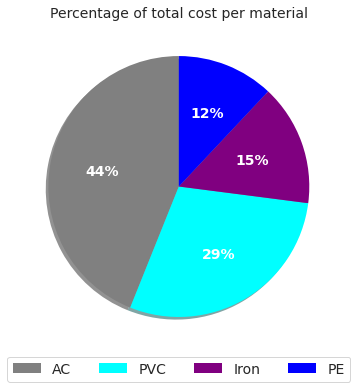

In [9]:
def getCostRatePerMaterialPie(failuresP,label,pale=pal):
    
    matLengh= failuresP.groupby([MATERIAL]).agg({'Shape_Leng': sum}).copy()
    
    failNCost= failuresP.join(costs, on=SERVNO)[[MATERIAL,'WoCost','Shape_Leng']].copy()
    failNCostMate= failNCost.groupby([MATERIAL]).agg({'WoCost': sum})

    mateCost= failNCostMate.join(matLengh).copy()
    mateCost["%"]=mateCost['WoCost']/mateCost['WoCost'].sum()
     
    print("total NZD spended in the 6 years in predominant materials ", mateCost['WoCost'].sum())
    print("total number of failures in the 6 years of predominant materials ", failuresP.shape[0])

    #start of the graph
    fig1, ax  = plt.subplots(figsize=(12,6))

    ax.pie( mateCost["%"],labels=mateCost.index, textprops={'color':"w",'fontsize':14,'weight':'bold'},
        autopct='%1.0f%%',colors=pale, shadow=True, startangle=90,labeldistance=None,wedgeprops={'linewidth': 0})

    ax.legend(loc='upper center', bbox_to_anchor=(0.5,0), ncol=7, facecolor='white',fontsize=14)
    ax.set_title('Percentage of total cost per material',fontsize=14)
    
    fig1.savefig('Maps_Graph/CostAnalysis/'+ 'MateDistributiCost' + '.png', dpi=200, bbox_inches='tight' )



getCostRatePerMaterialPie(failuresPMaterials,"All")

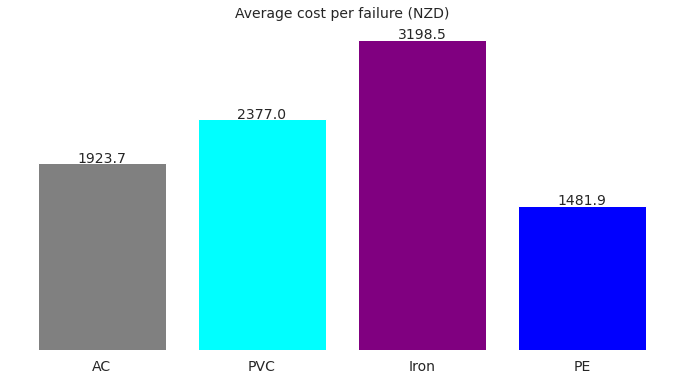

In [28]:
def getCostRatePerMaterial(failuresP, label):
    
    matNFailures= failuresP.groupby([MATERIAL]).agg({ACTCODE: 'count'}).copy()
    
    failNCost= failuresP.join(costs, on=SERVNO)[[MATERIAL,'WoCost']].copy()
    failNCostMate= failNCost.groupby([MATERIAL]).agg({'WoCost': sum})

    mateCost= failNCostMate.join(matNFailures).copy()
    mateCost["$/failures"]=mateCost['WoCost']/mateCost[ACTCODE].copy()

    #start of the graph
    fig1, ax  = plt.subplots(figsize=(12,6))

    bars = ax.bar(mateCost.index,mateCost["$/failures"], color= pal)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_title('Average cost per failure (NZD)',fontsize=14)
    plt.yticks([])

    for bar in bars:
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height()+10,
            round(bar.get_height(), 1),
            horizontalalignment='center'
        )
    
    fig1.savefig('Maps_Graph/CostAnalysis/'+ 'MateCostrate' +label+ '.png', dpi=200, bbox_inches='tight' )


        
getCostRatePerMaterial(failuresPMaterials,"All")

(Main in service) Pipe length with valid  NOM_DIA_MM  1691.54  from original  1709.67


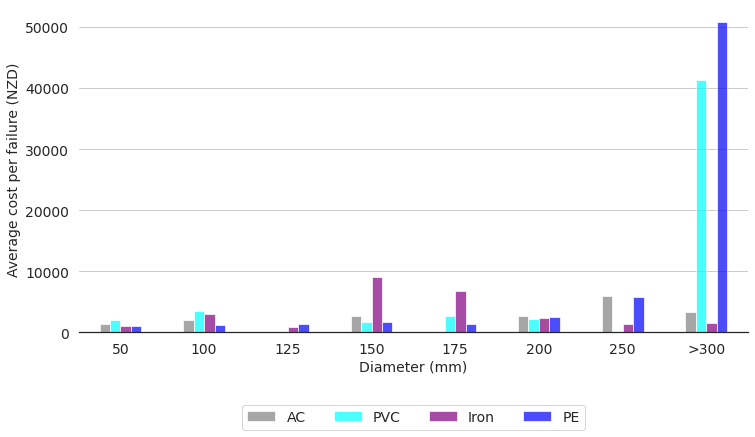

In [101]:
def putInRanges(df,colRanges,col,bins,labels,getValidationVals,startCol,finishCol):
    
    df[colRanges]= pd.cut(df[col], bins=bins, labels=labels)
    #remove invalid values (nulls)----------------------------------
    dfOK= df[~pd.isna(df[colRanges])].copy()
    
    if getValidationVals is not None:
        const= getValidationVals()
        for i in const.index:
            dfOK = dfOK.drop(dfOK[(dfOK.MATERIAL == i) & (dfOK[col]<const.loc[i, startCol])].index)
            dfOK = dfOK.drop(dfOK[(dfOK.MATERIAL == i) & (dfOK[col]>const.loc[i,finishCol])].index)
    
    print("(Main in service) Pipe length with valid ",col+" ","%.2f" % dfOK['Shape_Leng'].sum()," from original ", "%.2f" % df['Shape_Leng'].sum())
    
    return dfOK

def getCostRatePerMaterialDiam(failuresP,label):
    
    #put into ranges and group by
    dfOK= putInRanges(failuresP,"Diameter (mm)","NOM_DIA_MM",Diam_bins,DRange_labels,None,None,None)
    
    matNFailures= dfOK.groupby([MATERIAL,DIAMETER]).agg({ACTCODE: 'count'}).copy()
    
    failNCost= dfOK.join(costs, on=SERVNO)[[MATERIAL,DIAMETER,'WoCost']].copy()
    failNCostMate= failNCost.groupby([MATERIAL,DIAMETER]).agg({'WoCost': sum})

    mateCost= failNCostMate.join(matNFailures).copy()
    mateCost["$/failures"]=mateCost['WoCost']/mateCost[ACTCODE].copy()
    
    materialsColumns = mateCost.reset_index().pivot(index=DIAMETER, columns=MATERIAL, values="$/failures")

    #start of the graph
    fig1, ax  = plt.subplots(figsize=(12,6))

    ax = materialsColumns.plot.bar( ax= ax, color= pal, alpha=0.7,rot=0)
   
    ax = removeTopRightFrame(ax)
    ax.spines['left'].set_visible(False)
    ax.grid(axis='y', which='both')
    ax.legend(ncol=4, facecolor='white',fontsize=14,loc='upper center', bbox_to_anchor=(0.5, -0.2))
    
    ax.set_ylabel('Average cost per failure (NZD)',fontsize=14)
    
    fig1.savefig('Maps_Graph/CostAnalysis/'+ 'DiamCostRate' +label+ '.png', dpi=200, bbox_inches='tight' )


    
        
getCostRatePerMaterialDiam(failuresPMaterials.copy(),"All")

In [108]:
#Filters the total table of valid records leaving only failures 
#related with failures on mains with predominan materials
actMainFailures= failureRecords[failureRecords[SERVNO].isin(failuresPMaterials[SERVNO].unique().tolist())].copy()

#filters the failures that also have activities with service pipes
failBoth = actMainFailures[actMainFailures[ACTCODE]=='WSLRPR'].copy()

#gets the service numbers of those failures
servBoth= failBoth[SERVNO].unique().tolist()

failOnlyMain= failuresPMaterials[~failuresPMaterials[SERVNO].isin(servBoth)].copy()

#failOnlyMain

total NZD spended in the 6 years in predominant materials  24053000.250000045
total number of failures in the 6 years of predominant materials  11885


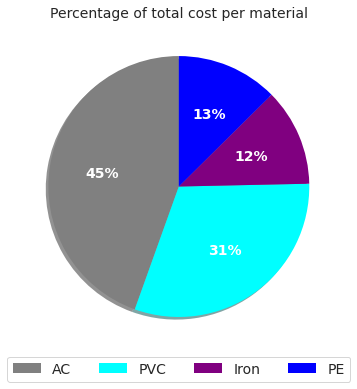

In [17]:
getCostRatePerMaterialPie(failOnlyMain.copy(),"Main")

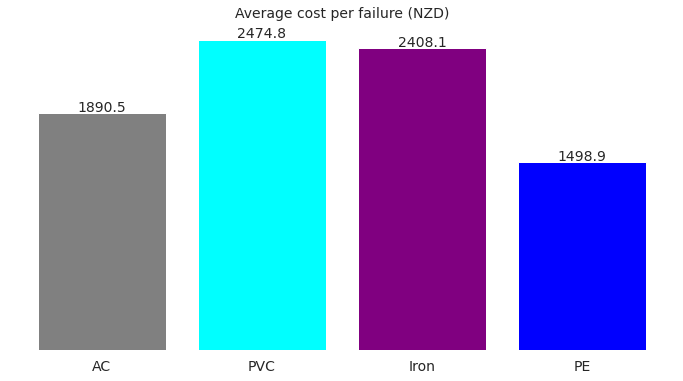

In [29]:
getCostRatePerMaterial(failOnlyMain.copy(),"Main")

(Main in service) Pipe length with valid  NOM_DIA_MM  1591.34  from original  1608.30


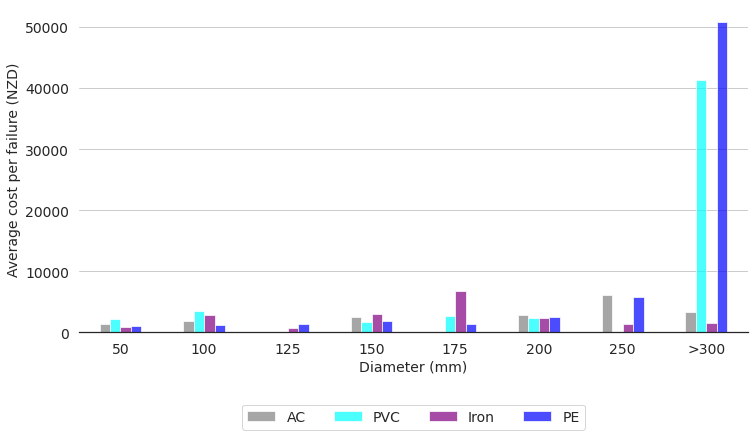

In [103]:
getCostRatePerMaterialDiam(failOnlyMain.copy(),"Main")

In [19]:
def getServiceFailures():

    fname = 'Data/03-WorkOrders.csv'

    numFailureRecordsOri=0
    failureServ, numFailureRecordsOri = getFailureRecords(numFailureRecordsOri)

    failureServ , numFailureRecordsOri = filters3PandNotRepairs(failureServ, SR_ToFilter, ACTCODERepair,numFailureRecordsOri)

    #divide between MAIN and SERViCE LINES------------------------------------------------
    serviFailures = failureServ[(failureServ[ACTCODE]=='WSLRPR')].copy()

    servPipe=getAssetsSERVRecords()[['Water Service Line Pipe Type','Water Service Line Length']]
    
    #adds material and length
    serviFailures=serviFailures.join(servPipe,on=COMPKEY).copy()
    serviFailures.rename(columns={'Water Service Line Pipe Type':MATERIAL,'Water Service Line Length':'Shape_Leng'
                                 }, inplace= True)

    serviFailures.fillna(value={"MATERIAL": 'UNK'},inplace=True)
    
    serviFailures[MATERIAL] = serviFailures[MATERIAL].replace(ALK, PE)
    serviFailures[MATERIAL] = serviFailures[MATERIAL].replace(DI, IRON)
    
    return serviFailures

servFailures=getServiceFailures()

Number of records from the DB query: 590379
Number of failure records: 590271  Deleted records duplicated WONO:  108
Number of failure records: 570948  Deleted records:  19323
Number of failure records: 558467  3P Deleted records:  12481
Number of failure records: 92691  Not repair Deleted records:  465776
There are  947908  water mains in the database (NOT GIS)
There are  947908  water mains not duplicated in the database (NOT GIS)


total NZD spended in the 6 years in predominant materials  31966347.700001314
total number of failures in the 6 years of predominant materials  77956


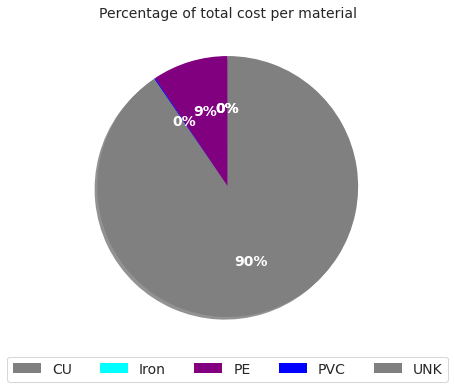

In [20]:
getCostRatePerMaterialPie(servFailures,['yellow','purple', 'blue','cyan', 'black'])

total NZD spended in the 6 years in predominant materials  29713045.27000097
total number of failures in the 6 years of predominant materials  77253


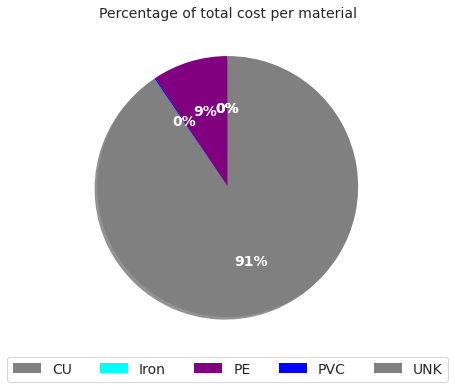

In [21]:
failOnlySERV= servFailures[~servFailures[SERVNO].isin(servBoth)].copy()

getCostRatePerMaterialPie(failOnlySERV,['yellow','purple', 'blue','cyan', 'black'])

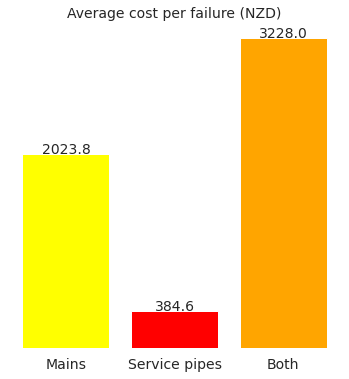

In [22]:
def getCostRatePerPipeType():

    df2 = pd.DataFrame([["Mains",2023.8],
                       ["Service pipes",384.6],
                        ["Both",3228.0]
                       ], columns=["Type of pipe","Cost rate (NZD/failures)"])

    fig1, ax = plt.subplots(figsize=(6,6))

    bars = ax.bar(df2['Type of pipe'], df2['Cost rate (NZD/failures)'],color=['yellow','red', 'orange'])

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.yticks([])
    ax.set_xlabel('Average cost per failure (NZD)')
    ax.xaxis.set_label_position('top') 

    for bar in bars:
        ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height()+0.005,
        round(bar.get_height(), 3),
        horizontalalignment='center'
    )
        
    fig1.savefig('Maps_Graph/CostAnalysis/'+ 'CostRateMainsVsServ' + '.png', dpi=200, bbox_inches='tight' )


getCostRatePerPipeType()

total NZD spended in the 6 years in predominant materials  2230562.0499999984
total number of failures in the 6 years of predominant materials  691


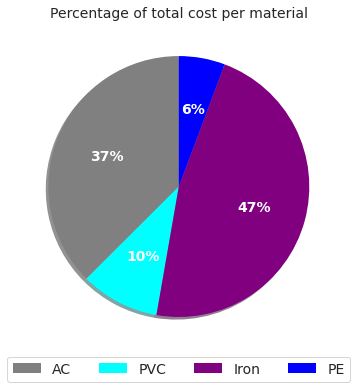

In [110]:
failBoth= failuresPMaterials[failuresPMaterials[SERVNO].isin(servBoth)].copy()

getCostRatePerMaterialPie(failBoth,"Both")


In [116]:
def getCostRatePerMaterialDiamBroken(failuresP,label):
    
    #put into ranges and group by
    dfOK= putInRanges(failuresP,"Diameter (mm)","NOM_DIA_MM",Diam_bins,DRange_labels,None,None,None)
    
    matNFailures= dfOK.groupby([MATERIAL,DIAMETER]).agg({ACTCODE: 'count'}).copy()
    
    failNCost= dfOK.join(costs, on=SERVNO)[[MATERIAL,DIAMETER,'WoCost']].copy()
    failNCostMate= failNCost.groupby([MATERIAL,DIAMETER]).agg({'WoCost': sum})

    mateCost= failNCostMate.join(matNFailures).copy()
    mateCost["$/failures"]=mateCost['WoCost']/mateCost[ACTCODE].copy()
    
    materialsColumns = mateCost.reset_index().pivot(index=DIAMETER,columns=MATERIAL, values="$/failures")

    #start of the graph
    fig1, (ax,ax2)  = plt.subplots(2,figsize=(12,6),sharex=True,gridspec_kw={'height_ratios': [1, 3]})
    
    ax = materialsColumns.plot.bar( ax= ax, color= pal, alpha=0.7)
    ax2 = materialsColumns.plot.bar( ax= ax2, color= pal, alpha=0.7,rot=0)
    
    ax.spines['bottom'].set_visible(False)
    ax2 = removeTopRightFrame(ax2)
    ax2.spines['left'].set_visible(False)
    
    d = .015  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((-d, +d), (-d-0.05, +d), **kwargs)        # top-left diagonal
    ax.plot((1 - d, 1 + d), (-d-0.05, +d+.05-0.05), **kwargs)  # top-right diagonal

    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1.1 - d, 1.1 + d), **kwargs)  # bottom-left diagonal
    ax2.plot((1 - d, 1 + d), (1.1 - d, 1.1 + d), **kwargs)  # bottom-right diagonal
    
    
    ax.set_ylim(bottom= 20000)  # outliers only
    ax2.set_ylim(0, 15000)
      
    ax = removeTopRightFrame(ax)
    ax.spines['left'].set_visible(False)
    ax2.grid(axis='y', which='both')
    ax.grid(axis='y', which='both')
    ax.legend().remove()
    ax2.legend(ncol=4, facecolor='white',fontsize=14,loc='upper center', bbox_to_anchor=(0.5, -0.2))
    
    fig1.text(0.02, 0.5, 'Average cost per failure (NZD)', va='center', rotation='vertical',fontsize=14)
   
    fig1.savefig('Maps_Graph/CostAnalysis/'+ 'CostDiamSegre' + '.png', dpi=200, bbox_inches='tight' )
    
    

(Main in service) Pipe length with valid  NOM_DIA_MM  100.20  from original  101.37


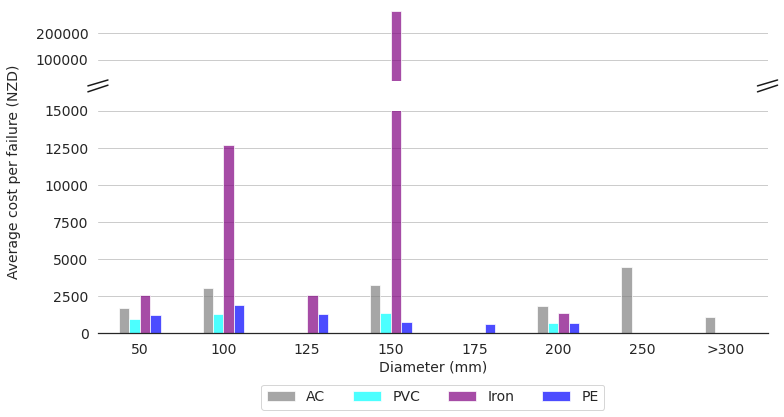

In [117]:
#getCostRatePerMaterial(failBoth.copy(),"Both")
getCostRatePerMaterialDiamBroken(failBoth.copy(),"Both")

In [36]:
failureCost = pd.read_csv(fname, delimiter = ',',
                                 dtype = {SERVNO:'str','WoCost':'float64'},
                                )

/home/ubuntu/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (0,10,17,22,24) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [40]:
failureCost[failureCost[SERVNO]=='14782492']

,WONO,ACTCODE,WoCost,Contractor,CONTAREA,COMPKEY,AssetType,SERVNO,ADDDTTM,SR_PROB,...,SUBURB,POSTCODE,WO_COMP_DATE,Install Date,Size_Diam,Age (months),Name,Pipelen,Pipetype,DPTH
298097,9043276,WHYREN,819436.29,MSN,METRO,8521695,Hydrant,14782492,2018-11-28 09:46:01.000,FWM1,...,PENROSE,1061,2018-11-29,1960-03-22,100,704.0,NaN,0.0,NaN,0.0
300688,9043255,WVREN,NaN,MSN,METRO,8568808,Water Valve,14782492,2018-11-28 09:46:01.000,FWM1,...,PENROSE,1061,2018-11-29,1998-08-01,150,243.0,NaN,0.0,NaN,0.0
313800,9052009,WMNRM,NaN,MSN,METRO,8719833,Water Main,14782492,2018-11-28 09:46:01.000,FWM1,...,PENROSE,1061,2018-12-15,1964-02-03,150,658.0,NaN,101.0,DI,-999.0
495195,9052007,WVNEW,9653.52,MSN,METRO,50046674,Water Valve,14782492,2018-11-28 09:46:01.000,FWM1,...,PENROSE,1061,2018-12-15,2012-07-02,0,77.0,NaN,0.0,NaN,0.0
530932,9052011,WSLRPR,NaN,MSN,METRO,50163892,Water Service Line,14782492,2018-11-28 09:46:01.000,FWM1,...,PENROSE,1061,2018-12-15,NaN,0,NaN,NaN,0.0,NaN,0.0


In [44]:
failureCost[failureCost[SERVNO]=='15111928'].iloc[:,8:19]

,ADDDTTM,SR_PROB,Contractor Reference Number,Resolution,FLAT,HOUSENO,Street_Name,Street_Type,SUBURB,POSTCODE,WO_COMP_DATE
314619,2019-04-17 00:21:10.000,FWLM,300182546,CLOSED,RES1,17,AUBURN,ST,GRAFTON,1023,2019-04-24
532091,2019-04-17 00:21:10.000,FWLM,300182546,COMP,RES1,17,AUBURN,ST,GRAFTON,1023,2019-04-24
532092,2019-04-17 00:21:10.000,FWLM,300182546,COMP,RES1,17,AUBURN,ST,GRAFTON,1023,2019-04-24
532093,2019-04-17 00:21:10.000,FWLM,300182546,COMP,RES1,17,AUBURN,ST,GRAFTON,1023,2019-04-24
532094,2019-04-17 00:21:10.000,FWLM,300182546,COMP,RES1,17,AUBURN,ST,GRAFTON,1023,2019-04-24
532095,2019-04-17 00:21:10.000,FWLM,300182546,COMP,RES1,17,AUBURN,ST,GRAFTON,1023,2019-04-24
532096,2019-04-17 00:21:10.000,FWLM,300182546,COMP,RES1,17,AUBURN,ST,GRAFTON,1023,2019-04-24
538933,2019-04-17 00:21:10.000,FWLM,300182546,COMP,RES1,17,AUBURN,ST,GRAFTON,1023,2019-04-24
538934,2019-04-17 00:21:10.000,FWLM,300182546,COMP,RES1,17,AUBURN,ST,GRAFTON,1023,2019-04-24
538935,2019-04-17 00:21:10.000,FWLM,300182546,COMP,RES1,17,AUBURN,ST,GRAFTON,1023,2019-04-24
